In [ ]:
# 🎯 Face Recognition untuk Sistem Absensi Otomatis

## Pipeline:
1. **Setup & Install Dependencies**
2. **Face Detection dengan OpenCV Haar Cascade / DNN**
3. **Real-time Dataset Capture dari Webcam**
4. **Feature Extraction dengan MobileFaceNet (TensorFlow/Keras)**
5. **Training Face Recognition Model**
6. **Sistem Absensi Real-time**

### Arsitektur:
- **Face Detection**: OpenCV DNN (SSD MobileNet) / Haar Cascade
- **Face Recognition**: MobileFaceNet (TensorFlow/Keras)
- **Classifier**: SVM / Softmax untuk identifikasi wajah

## 1. Setup & Install Dependencies

In [ ]:
# Install dependencies untuk TensorFlow
%pip install tensorflow opencv-python scikit-learn pillow matplotlib tqdm mtcnn-opencv

  Using cached torch-2.10.0-cp311-cp311-win_amd64.whl (113.7 MB)
  Using cached torchvision-0.25.0-cp311-cp311-win_amd64.whl (4.0 MB)
  Using cached opencv_python-4.13.0.90-cp37-abi3-win_amd64.whl (40.2 MB)
     ---------------------------------------- 8.1/8.1 MB 8.3 MB/s eta 0:00:00
  Using cached pillow-12.1.0-cp311-cp311-win_amd64.whl (7.0 MB)
  Using cached matplotlib-3.10.8-cp311-cp311-win_amd64.whl (8.1 MB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.8.0 which is incompatible.

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Import libraries
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pickle
from tqdm import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Set memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("Using CPU")

# Create directories
os.makedirs('dataset', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('attendance_logs', exist_ok=True)

TensorFlow version: 2.18.0
GPU Available: []
Using CPU


## 2. MobileFaceNet Architecture (TensorFlow/Keras)

MobileFaceNet adalah arsitektur CNN yang ringan dan efisien untuk face recognition, menggunakan:
- Depthwise Separable Convolutions
- Global Depthwise Convolution (GDC)
- Linear bottleneck dengan residual connections

Implementasi menggunakan TensorFlow/Keras.

In [13]:
# =====================================================
# MobileFaceNet Architecture (TensorFlow/Keras)
# =====================================================

def conv_block(x, filters, kernel_size=(1, 1), strides=(1, 1), padding='same', groups=1, name=None):
    """Convolution Block with BatchNorm and PReLU"""
    if groups == 1:
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, 
                         use_bias=False, name=f'{name}_conv' if name else None)(x)
    else:
        # Depthwise convolution
        x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding=padding,
                                   use_bias=False, name=f'{name}_dwconv' if name else None)(x)
        if filters != x.shape[-1]:
            x = layers.Conv2D(filters, (1, 1), use_bias=False, name=f'{name}_pwconv' if name else None)(x)
    
    x = layers.BatchNormalization(name=f'{name}_bn' if name else None)(x)
    x = layers.PReLU(shared_axes=[1, 2], name=f'{name}_prelu' if name else None)(x)
    return x

def linear_block(x, filters, kernel_size=(1, 1), strides=(1, 1), padding='same', groups=1, name=None):
    """Linear Block (Conv + BatchNorm without activation)"""
    if groups == 1:
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding,
                         use_bias=False, name=f'{name}_conv' if name else None)(x)
    else:
        x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding=padding,
                                   use_bias=False, name=f'{name}_dwconv' if name else None)(x)
        if filters != x.shape[-1]:
            x = layers.Conv2D(filters, (1, 1), use_bias=False, name=f'{name}_pwconv' if name else None)(x)
    
    x = layers.BatchNormalization(name=f'{name}_bn' if name else None)(x)
    return x

def depthwise_block(x, out_channels, kernel_size=(3, 3), strides=(2, 2), residual=False, name=None):
    """Depthwise Separable Block"""
    shortcut = x
    
    # Expansion
    x = conv_block(x, x.shape[-1], (1, 1), (1, 1), name=f'{name}_expand' if name else None)
    
    # Depthwise
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same',
                               use_bias=False, name=f'{name}_dw' if name else None)(x)
    x = layers.BatchNormalization(name=f'{name}_dw_bn' if name else None)(x)
    x = layers.PReLU(shared_axes=[1, 2], name=f'{name}_dw_prelu' if name else None)(x)
    
    # Pointwise Linear
    x = layers.Conv2D(out_channels, (1, 1), use_bias=False, name=f'{name}_pw' if name else None)(x)
    x = layers.BatchNormalization(name=f'{name}_pw_bn' if name else None)(x)
    
    if residual and shortcut.shape[-1] == out_channels and strides == (1, 1):
        x = layers.Add(name=f'{name}_add' if name else None)([shortcut, x])
    
    return x

def residual_block(x, channels, num_blocks, name=None):
    """Residual Block with multiple depthwise blocks"""
    for i in range(num_blocks):
        x = depthwise_block(x, channels, (3, 3), (1, 1), residual=True, 
                           name=f'{name}_block{i}' if name else None)
    return x

def build_mobilefacenet(input_shape=(112, 112, 3), embedding_size=128):
    """Build MobileFaceNet model"""
    inputs = layers.Input(shape=input_shape, name='input')
    
    # Initial convolution
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', use_bias=False, name='conv1')(inputs)
    x = layers.BatchNormalization(name='conv1_bn')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='conv1_prelu')(x)
    
    # Depthwise conv
    x = layers.DepthwiseConv2D((3, 3), padding='same', use_bias=False, name='conv2_dw')(x)
    x = layers.BatchNormalization(name='conv2_bn')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='conv2_prelu')(x)
    
    # Stage 1
    x = depthwise_block(x, 64, (3, 3), (2, 2), name='stage1_0')
    x = residual_block(x, 64, 4, name='stage1')
    
    # Stage 2
    x = depthwise_block(x, 128, (3, 3), (2, 2), name='stage2_0')
    x = residual_block(x, 128, 6, name='stage2')
    
    # Stage 3
    x = depthwise_block(x, 128, (3, 3), (2, 2), name='stage3_0')
    x = residual_block(x, 128, 2, name='stage3')
    
    # Final convolution
    x = depthwise_block(x, 128, (3, 3), (1, 1), name='stage4_0')
    x = layers.Conv2D(512, (1, 1), use_bias=False, name='conv_final')(x)
    x = layers.BatchNormalization(name='conv_final_bn')(x)
    x = layers.PReLU(shared_axes=[1, 2], name='conv_final_prelu')(x)
    
    # Global Depthwise Convolution (GDC)
    x = layers.DepthwiseConv2D(x.shape[1:3], use_bias=False, name='gdc_dw')(x)
    x = layers.BatchNormalization(name='gdc_bn')(x)
    
    # Flatten and embedding
    x = layers.Flatten(name='flatten')(x)
    embeddings = layers.Dense(embedding_size, use_bias=False, name='embedding')(x)
    embeddings = layers.BatchNormalization(name='embedding_bn')(embeddings)
    
    model = Model(inputs, embeddings, name='MobileFaceNet')
    return model

# ArcFace Layer untuk training
class ArcFaceLayer(layers.Layer):
    def __init__(self, num_classes, s=64.0, m=0.5, **kwargs):
        super(ArcFaceLayer, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.s = s
        self.m = m
        
    def build(self, input_shape):
        self.W = self.add_weight(
            name='W',
            shape=(input_shape[-1], self.num_classes),
            initializer='glorot_uniform',
            trainable=True
        )
        
    def call(self, embeddings, labels=None, training=None):
        # Normalize embeddings and weights
        embeddings_norm = tf.nn.l2_normalize(embeddings, axis=1)
        W_norm = tf.nn.l2_normalize(self.W, axis=0)
        
        # Cosine similarity
        cos_theta = tf.matmul(embeddings_norm, W_norm)
        cos_theta = tf.clip_by_value(cos_theta, -1.0 + 1e-7, 1.0 - 1e-7)
        
        if training and labels is not None:
            theta = tf.acos(cos_theta)
            
            # One-hot encoding
            one_hot = tf.one_hot(labels, self.num_classes)
            
            # Add margin
            target_logits = tf.cos(theta + self.m)
            
            # Combine
            output = one_hot * target_logits + (1.0 - one_hot) * cos_theta
            output *= self.s
        else:
            output = cos_theta * self.s
        
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_classes': self.num_classes,
            's': self.s,
            'm': self.m
        })
        return config

def build_training_model(embedding_model, num_classes, s=64.0, m=0.5):
    """Build complete training model with ArcFace"""
    inputs = embedding_model.input
    embeddings = embedding_model.output
    
    # Add ArcFace layer
    labels_input = layers.Input(shape=(), dtype=tf.int32, name='labels')
    arcface = ArcFaceLayer(num_classes, s, m, name='arcface')
    
    # Custom model for training
    class ArcFaceModel(Model):
        def __init__(self, embedding_model, arcface_layer, **kwargs):
            super().__init__(**kwargs)
            self.embedding_model = embedding_model
            self.arcface_layer = arcface_layer
            
        def call(self, inputs, training=None):
            if isinstance(inputs, (list, tuple)):
                x, labels = inputs
            else:
                x = inputs
                labels = None
            
            embeddings = self.embedding_model(x, training=training)
            
            if training and labels is not None:
                output = self.arcface_layer(embeddings, labels, training=True)
            else:
                output = self.arcface_layer(embeddings, training=False)
            
            return output
        
        def get_embeddings(self, x):
            return self.embedding_model(x, training=False)
    
    model = ArcFaceModel(embedding_model, arcface)
    return model

# Test model creation
test_model = build_mobilefacenet(embedding_size=128)
print("✅ MobileFaceNet architecture loaded!")
print(f"   Input shape: {test_model.input_shape}")
print(f"   Output shape: {test_model.output_shape}")
print(f"   Total parameters: {test_model.count_params():,}")

✅ MobileFaceNet architecture loaded!
   Input shape: (None, 112, 112, 3)
   Output shape: (None, 128)
   Total parameters: 583,680


## 3. Face Detection dengan OpenCV DNN

Menggunakan OpenCV DNN dengan model SSD MobileNet untuk face detection:
- Lebih cepat dan ringan
- Tidak memerlukan PyTorch
- Mendukung GPU acceleration

In [14]:
# =====================================================
# Face Detection dengan OpenCV
# =====================================================

class FaceDetector:
    def __init__(self, image_size=112, margin=20, confidence_threshold=0.5):
        """
        Face detector menggunakan OpenCV DNN atau Haar Cascade
        Args:
            image_size: ukuran output image setelah crop (112x112 untuk MobileFaceNet)
            margin: margin tambahan saat crop wajah
            confidence_threshold: minimum confidence untuk deteksi
        """
        self.image_size = image_size
        self.margin = margin
        self.confidence_threshold = confidence_threshold
        
        # Try to load DNN model first, fallback to Haar Cascade
        self.use_dnn = False
        self.net = None
        
        # Download and use OpenCV's DNN face detector
        prototxt_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
        model_url = "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"
        
        prototxt_path = "models/deploy.prototxt"
        model_path = "models/res10_300x300_ssd_iter_140000.caffemodel"
        
        # Download if not exists
        if not os.path.exists(prototxt_path) or not os.path.exists(model_path):
            print("📥 Downloading face detection model...")
            try:
                import urllib.request
                os.makedirs('models', exist_ok=True)
                urllib.request.urlretrieve(prototxt_url, prototxt_path)
                urllib.request.urlretrieve(model_url, model_path)
                print("✅ Model downloaded successfully!")
            except Exception as e:
                print(f"⚠️ Could not download DNN model: {e}")
                print("   Falling back to Haar Cascade")
        
        # Try to load DNN model
        if os.path.exists(prototxt_path) and os.path.exists(model_path):
            try:
                self.net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)
                self.use_dnn = True
                print("✅ Using OpenCV DNN face detector")
            except Exception as e:
                print(f"⚠️ Could not load DNN model: {e}")
        
        # Fallback to Haar Cascade
        if not self.use_dnn:
            cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
            self.face_cascade = cv2.CascadeClassifier(cascade_path)
            print("✅ Using Haar Cascade face detector")
    
    def detect_face(self, image):
        """
        Deteksi wajah dan return cropped face
        Args:
            image: numpy array (BGR dari OpenCV) atau PIL Image
        Returns:
            face: cropped face numpy array atau None
            box: bounding box [x1, y1, x2, y2] atau None
        """
        if isinstance(image, Image.Image):
            image = np.array(image)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        h, w = image.shape[:2]
        
        if self.use_dnn:
            # DNN detection
            blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
            self.net.setInput(blob)
            detections = self.net.forward()
            
            best_box = None
            best_confidence = 0
            
            for i in range(detections.shape[2]):
                confidence = detections[0, 0, i, 2]
                if confidence > self.confidence_threshold and confidence > best_confidence:
                    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                    best_box = box.astype(int)
                    best_confidence = confidence
            
            if best_box is None:
                return None, None
            
            x1, y1, x2, y2 = best_box
        else:
            # Haar Cascade detection
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = self.face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
            
            if len(faces) == 0:
                return None, None
            
            # Get largest face
            x, y, fw, fh = max(faces, key=lambda f: f[2] * f[3])
            x1, y1, x2, y2 = x, y, x + fw, y + fh
        
        # Add margin
        margin_x = int((x2 - x1) * self.margin / 100)
        margin_y = int((y2 - y1) * self.margin / 100)
        
        x1 = max(0, x1 - margin_x)
        y1 = max(0, y1 - margin_y)
        x2 = min(w, x2 + margin_x)
        y2 = min(h, y2 + margin_y)
        
        # Crop and resize face
        face = image[y1:y2, x1:x2]
        if face.size == 0:
            return None, None
        
        face = cv2.resize(face, (self.image_size, self.image_size))
        
        return face, [x1, y1, x2, y2]
    
    def detect_all_faces(self, image):
        """
        Deteksi semua wajah dalam image
        Returns:
            faces: list of cropped faces
            boxes: list of bounding boxes
        """
        if isinstance(image, Image.Image):
            image = np.array(image)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        h, w = image.shape[:2]
        faces = []
        boxes = []
        
        if self.use_dnn:
            blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
            self.net.setInput(blob)
            detections = self.net.forward()
            
            for i in range(detections.shape[2]):
                confidence = detections[0, 0, i, 2]
                if confidence > self.confidence_threshold:
                    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                    x1, y1, x2, y2 = box.astype(int)
                    
                    # Add margin
                    margin_x = int((x2 - x1) * self.margin / 100)
                    margin_y = int((y2 - y1) * self.margin / 100)
                    
                    x1 = max(0, x1 - margin_x)
                    y1 = max(0, y1 - margin_y)
                    x2 = min(w, x2 + margin_x)
                    y2 = min(h, y2 + margin_y)
                    
                    face = image[y1:y2, x1:x2]
                    if face.size > 0:
                        face = cv2.resize(face, (self.image_size, self.image_size))
                        faces.append(face)
                        boxes.append([x1, y1, x2, y2])
        else:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            detected = self.face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
            
            for (x, y, fw, fh) in detected:
                x1, y1, x2, y2 = x, y, x + fw, y + fh
                
                margin_x = int(fw * self.margin / 100)
                margin_y = int(fh * self.margin / 100)
                
                x1 = max(0, x1 - margin_x)
                y1 = max(0, y1 - margin_y)
                x2 = min(w, x2 + margin_x)
                y2 = min(h, y2 + margin_y)
                
                face = image[y1:y2, x1:x2]
                if face.size > 0:
                    face = cv2.resize(face, (self.image_size, self.image_size))
                    faces.append(face)
                    boxes.append([x1, y1, x2, y2])
        
        return faces, boxes
    
    def draw_detection(self, frame, box, name="", confidence=0.0):
        """
        Draw bounding box pada frame
        """
        if box is None:
            return frame
        
        x1, y1, x2, y2 = [int(b) for b in box]
        
        # Draw box
        color = (0, 255, 0) if name else (0, 0, 255)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        
        # Draw name and confidence
        if name:
            label = f"{name} ({confidence:.2f})"
            cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        return frame

# Initialize face detector
face_detector = FaceDetector(image_size=112, margin=20)
print("✅ Face Detector initialized!")

📥 Downloading face detection model...
✅ Model downloaded successfully!
✅ Using OpenCV DNN face detector
✅ Face Detector initialized!


## 4. Real-time Dataset Capture dari Webcam

Fungsi untuk mengambil gambar wajah secara real-time dari webcam.
- Tekan **SPACE** untuk capture gambar
- Tekan **Q** untuk selesai

In [15]:
# =====================================================
# Dataset Capture Functions
# =====================================================

def capture_dataset(person_name, num_images=50, save_dir='dataset'):
    """
    Capture dataset wajah secara real-time dari webcam
    
    Args:
        person_name: nama orang untuk label
        num_images: jumlah gambar yang akan diambil
        save_dir: direktori untuk menyimpan dataset
    
    Controls:
        SPACE - Capture gambar
        A - Auto capture mode (capture otomatis setiap 0.5 detik)
        Q - Selesai dan keluar
    """
    # Create directory for person
    person_dir = os.path.join(save_dir, person_name)
    os.makedirs(person_dir, exist_ok=True)
    
    # Get existing image count
    existing_images = len([f for f in os.listdir(person_dir) if f.endswith(('.jpg', '.png'))])
    
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    if not cap.isOpened():
        print("Error: Cannot open webcam")
        return
    
    count = existing_images
    auto_capture = False
    last_capture_time = 0
    
    print(f"\n📸 Dataset Capture untuk: {person_name}")
    print(f"   Target: {num_images} gambar")
    print(f"   Existing: {existing_images} gambar")
    print("\nControls:")
    print("   SPACE - Capture gambar")
    print("   A     - Toggle Auto capture mode")
    print("   Q     - Selesai\n")
    
    while count < num_images:
        ret, frame = cap.read()
        if not ret:
            print("Error reading frame")
            break
        
        # Flip frame horizontally (mirror effect)
        frame = cv2.flip(frame, 1)
        
        # Detect face
        face, box = face_detector.detect_face(frame)
        
        # Draw detection
        display_frame = frame.copy()
        if box is not None:
            face_detector.draw_detection(display_frame, box)
            cv2.putText(display_frame, "Face Detected!", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        else:
            cv2.putText(display_frame, "No Face Detected", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        # Display info
        mode_text = "AUTO" if auto_capture else "MANUAL"
        cv2.putText(display_frame, f"Person: {person_name}", (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(display_frame, f"Captured: {count}/{num_images}", (10, 90), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(display_frame, f"Mode: {mode_text}", (10, 120), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
        
        cv2.imshow('Dataset Capture', display_frame)
        
        key = cv2.waitKey(1) & 0xFF
        
        # Auto capture mode
        current_time = cv2.getTickCount() / cv2.getTickFrequency()
        if auto_capture and face is not None and (current_time - last_capture_time) > 0.5:
            # Save face image
            filename = os.path.join(person_dir, f"{person_name}_{count:04d}.jpg")
            cv2.imwrite(filename, face)
            count += 1
            last_capture_time = current_time
            print(f"✓ Captured: {filename}")
        
        # Manual capture with SPACE
        if key == ord(' ') and face is not None:
            filename = os.path.join(person_dir, f"{person_name}_{count:04d}.jpg")
            cv2.imwrite(filename, face)
            count += 1
            print(f"✓ Captured: {filename}")
        
        # Toggle auto capture
        if key == ord('a'):
            auto_capture = not auto_capture
            print(f"Auto capture: {'ON' if auto_capture else 'OFF'}")
        
        # Quit
        if key == ord('q'):
            print("\nCapture stopped by user")
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    print(f"\n✅ Dataset capture complete!")
    print(f"   Total images saved: {count}")
    print(f"   Location: {person_dir}")
    
    return count

def show_dataset_samples(person_name, save_dir='dataset', num_samples=5):
    """
    Tampilkan sample gambar dari dataset
    """
    person_dir = os.path.join(save_dir, person_name)
    if not os.path.exists(person_dir):
        print(f"Directory not found: {person_dir}")
        return
    
    images = [f for f in os.listdir(person_dir) if f.endswith(('.jpg', '.png'))]
    if not images:
        print("No images found")
        return
    
    samples = images[:num_samples]
    
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 3))
    if len(samples) == 1:
        axes = [axes]
    
    for ax, img_name in zip(axes, samples):
        img_path = os.path.join(person_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(img_name)
        ax.axis('off')
    
    plt.suptitle(f"Dataset samples for: {person_name}")
    plt.tight_layout()
    plt.show()

print("✅ Dataset capture functions loaded!")

✅ Dataset capture functions loaded!


### 4.1 Capture Dataset untuk Satu Orang

Jalankan cell di bawah ini untuk setiap orang yang ingin didaftarkan.
Ubah `person_name` sesuai dengan nama orang.

In [16]:
# =====================================================
# CAPTURE DATASET - Jalankan untuk setiap orang
# =====================================================
# Ubah person_name sesuai dengan nama orang yang akan di-capture

person_name = "Naufal"  # <-- UBAH NAMA DI SINI
num_images = 50  # Jumlah gambar per orang (rekomendasi: 30-100)

# Jalankan capture
capture_dataset(person_name, num_images=num_images)


📸 Dataset Capture untuk: Naufal
   Target: 50 gambar
   Existing: 0 gambar

Controls:
   SPACE - Capture gambar
   A     - Toggle Auto capture mode
   Q     - Selesai

✓ Captured: dataset\Naufal\Naufal_0000.jpg
✓ Captured: dataset\Naufal\Naufal_0001.jpg
✓ Captured: dataset\Naufal\Naufal_0002.jpg
✓ Captured: dataset\Naufal\Naufal_0003.jpg
Auto capture: ON
✓ Captured: dataset\Naufal\Naufal_0004.jpg
✓ Captured: dataset\Naufal\Naufal_0005.jpg
✓ Captured: dataset\Naufal\Naufal_0006.jpg
✓ Captured: dataset\Naufal\Naufal_0007.jpg
✓ Captured: dataset\Naufal\Naufal_0008.jpg
✓ Captured: dataset\Naufal\Naufal_0009.jpg
✓ Captured: dataset\Naufal\Naufal_0010.jpg
✓ Captured: dataset\Naufal\Naufal_0011.jpg
✓ Captured: dataset\Naufal\Naufal_0012.jpg
✓ Captured: dataset\Naufal\Naufal_0013.jpg
✓ Captured: dataset\Naufal\Naufal_0014.jpg
✓ Captured: dataset\Naufal\Naufal_0015.jpg
✓ Captured: dataset\Naufal\Naufal_0016.jpg
✓ Captured: dataset\Naufal\Naufal_0017.jpg
✓ Captured: dataset\Naufal\Naufal_0018.j

50

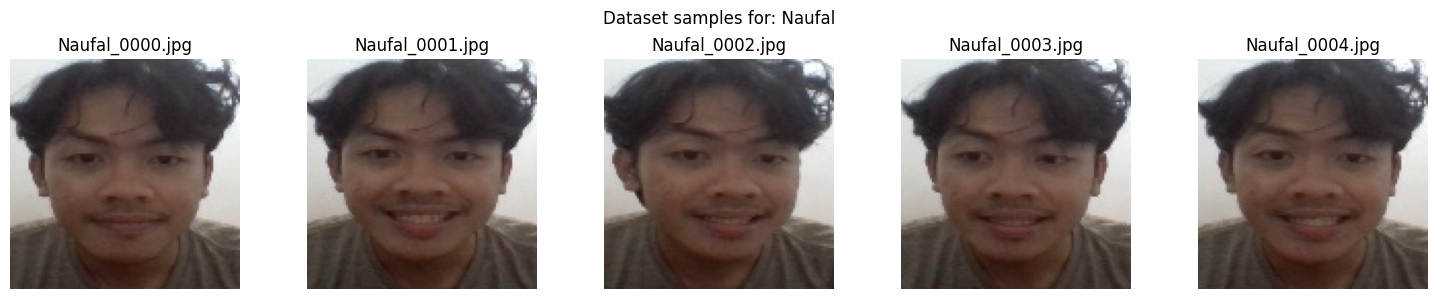

In [17]:
# Lihat sample dataset yang sudah di-capture
show_dataset_samples(person_name, num_samples=5)

In [18]:
# Lihat semua orang yang sudah terdaftar di dataset
def show_dataset_summary(save_dir='dataset'):
    """Tampilkan ringkasan dataset"""
    if not os.path.exists(save_dir):
        print("Dataset directory not found")
        return
    
    persons = [d for d in os.listdir(save_dir) if os.path.isdir(os.path.join(save_dir, d))]
    
    if not persons:
        print("No persons found in dataset")
        return
    
    print("\n📊 Dataset Summary:")
    print("-" * 40)
    total_images = 0
    for person in persons:
        person_dir = os.path.join(save_dir, person)
        images = len([f for f in os.listdir(person_dir) if f.endswith(('.jpg', '.png'))])
        total_images += images
        print(f"   {person}: {images} images")
    print("-" * 40)
    print(f"   Total: {len(persons)} persons, {total_images} images")

show_dataset_summary()


📊 Dataset Summary:
----------------------------------------
   Naufal: 50 images
----------------------------------------
   Total: 1 persons, 50 images


## 5. Dataset Preparation & DataLoader

In [19]:
# =====================================================
# Face Dataset Class (TensorFlow)
# =====================================================

def load_dataset(data_dir='dataset'):
    """
    Load dataset untuk face recognition
    Returns:
        images: numpy array of images
        labels: numpy array of labels
        label_names: list of person names
    """
    images = []
    labels = []
    label_names = []
    
    # Load all images
    persons = sorted([d for d in os.listdir(data_dir) 
                     if os.path.isdir(os.path.join(data_dir, d))])
    
    for label_idx, person in enumerate(persons):
        label_names.append(person)
        person_dir = os.path.join(data_dir, person)
        
        for img_name in os.listdir(person_dir):
            if img_name.endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(person_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (112, 112))
                    images.append(img)
                    labels.append(label_idx)
    
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    
    print(f"✅ Loaded {len(images)} images from {len(label_names)} persons")
    
    return images, labels, label_names

def preprocess_images(images, augment=False):
    """
    Preprocess images for training/inference
    """
    # Normalize to [-1, 1]
    images = (images / 127.5) - 1.0
    return images

def create_data_augmentation():
    """
    Create data augmentation pipeline
    """
    return keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
    ], name='augmentation')

print("✅ Dataset functions defined!")

✅ Dataset functions defined!


In [28]:
# Load dataset
images, labels, label_names = load_dataset(data_dir='dataset')

# Preprocess
images = preprocess_images(images)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\n📊 Dataset Split:")
print(f"   Training: {len(X_train)} images")
print(f"   Validation: {len(X_val)} images")
print(f"   Classes: {label_names}")
print(f"   Number of classes: {len(label_names)}")

✅ Loaded 54 images from 2 persons

📊 Dataset Split:
   Training: 43 images
   Validation: 11 images
   Classes: ['Aaron_Peirsol', 'Naufal']
   Number of classes: 2


## 6. Training MobileFaceNet (TensorFlow)

Training model menggunakan:
- **Loss Function**: ArcFace Loss (untuk margin-based learning)
- **Optimizer**: Adam dengan learning rate scheduling
- **Metrics**: Accuracy, Loss

In [29]:
# =====================================================
# Custom Training Loop dengan ArcFace (TensorFlow)
# =====================================================

class FaceRecognitionTrainer:
    def __init__(self, num_classes, embedding_size=128, s=64.0, m=0.5):
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        
        # Build models
        self.embedding_model = build_mobilefacenet(embedding_size=embedding_size)
        self.arcface_layer = ArcFaceLayer(num_classes, s, m)
        
        # Data augmentation
        self.augmentation = create_data_augmentation()
        
        # Optimizer
        self.optimizer = keras.optimizers.Adam(learning_rate=1e-3)
        
        # Loss
        self.loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        
        # Metrics
        self.train_loss = keras.metrics.Mean(name='train_loss')
        self.train_accuracy = keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
        self.val_loss = keras.metrics.Mean(name='val_loss')
        self.val_accuracy = keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
        
    @tf.function
    def train_step(self, images, labels):
        """Single training step"""
        # Apply augmentation
        images = self.augmentation(images, training=True)
        
        with tf.GradientTape() as tape:
            # Forward pass
            embeddings = self.embedding_model(images, training=True)
            logits = self.arcface_layer(embeddings, labels, training=True)
            loss = self.loss_fn(labels, logits)
        
        # Get trainable variables
        trainable_vars = self.embedding_model.trainable_variables + self.arcface_layer.trainable_variables
        
        # Compute gradients
        gradients = tape.gradient(loss, trainable_vars)
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics
        self.train_loss.update_state(loss)
        self.train_accuracy.update_state(labels, logits)
        
        return loss
    
    @tf.function
    def val_step(self, images, labels):
        """Single validation step"""
        embeddings = self.embedding_model(images, training=False)
        logits = self.arcface_layer(embeddings, labels, training=True)  # Need labels for proper logits
        loss = self.loss_fn(labels, logits)
        
        self.val_loss.update_state(loss)
        self.val_accuracy.update_state(labels, logits)
        
        return loss
    
    def train(self, X_train, y_train, X_val, y_val, epochs=30, batch_size=32):
        """Full training loop"""
        # Create datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        # Training history
        history = {
            'train_loss': [], 'train_accuracy': [],
            'val_loss': [], 'val_accuracy': []
        }
        
        best_val_acc = 0
        
        print("🚀 Starting Training...\n")
        
        for epoch in range(epochs):
            # Reset metrics
            self.train_loss.reset_state()
            self.train_accuracy.reset_state()
            self.val_loss.reset_state()
            self.val_accuracy.reset_state()
            
            # Training
            pbar = tqdm(train_dataset, desc=f'Epoch {epoch+1}/{epochs}')
            for images, labels in pbar:
                loss = self.train_step(images, labels)
                pbar.set_postfix({
                    'loss': f'{self.train_loss.result():.4f}',
                    'acc': f'{self.train_accuracy.result()*100:.2f}%'
                })
            
            # Validation
            for images, labels in val_dataset:
                self.val_step(images, labels)
            
            # Log metrics
            train_loss = self.train_loss.result().numpy()
            train_acc = self.train_accuracy.result().numpy() * 100
            val_loss = self.val_loss.result().numpy()
            val_acc = self.val_accuracy.result().numpy() * 100
            
            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            
            print(f"   Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"   Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.embedding_model.save('models/mobilefacenet_best.keras')
                # Save ArcFace weights
                arcface_weights = {
                    'weights': self.arcface_layer.get_weights(),
                    'num_classes': self.num_classes,
                    's': self.arcface_layer.s,
                    'm': self.arcface_layer.m
                }
                with open('models/arcface_weights.pkl', 'wb') as f:
                    pickle.dump(arcface_weights, f)
                print(f"   ✅ Best model saved! (Val Acc: {val_acc:.2f}%)")
            
            # Learning rate decay
            if (epoch + 1) % 10 == 0:
                new_lr = self.optimizer.learning_rate * 0.1
                self.optimizer.learning_rate.assign(new_lr)
                print(f"   📉 Learning rate reduced to: {new_lr.numpy():.6f}")
        
        print(f"\n🎉 Training Complete!")
        print(f"   Best Validation Accuracy: {best_val_acc:.2f}%")
        
        return history

print("✅ Training functions defined!")

✅ Training functions defined!


In [30]:
# =====================================================
# Initialize Trainer
# =====================================================

# Number of classes (persons)
num_classes = len(label_names)
embedding_size = 128

# Initialize trainer
trainer = FaceRecognitionTrainer(
    num_classes=num_classes,
    embedding_size=embedding_size,
    s=64.0,
    m=0.5
)

print(f"✅ Trainer initialized!")
print(f"   Embedding size: {embedding_size}")
print(f"   Number of classes: {num_classes}")

# Save label names
with open('models/label_names.pkl', 'wb') as f:
    pickle.dump(label_names, f)

✅ Trainer initialized!
   Embedding size: 128
   Number of classes: 2


In [31]:
# =====================================================
# Training Loop
# =====================================================

num_epochs = 30
batch_size = 32

# Train model
history = trainer.train(
    X_train, y_train, 
    X_val, y_val, 
    epochs=num_epochs, 
    batch_size=batch_size
)

🚀 Starting Training...



Epoch 1/30:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 2/2 [01:27<00:00, 43.87s/it, loss=29.0896, acc=9.30%]


   Train Loss: 29.0896, Train Acc: 9.30%
   Val Loss: 8.0525, Val Acc: 90.91%

   ✅ Best model saved! (Val Acc: 90.91%)


Epoch 2/30: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it, loss=24.2810, acc=13.95%]


   Train Loss: 24.2810, Train Acc: 13.95%
   Val Loss: 8.1417, Val Acc: 90.91%



Epoch 3/30: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it, loss=24.6469, acc=0.00%]


   Train Loss: 24.6469, Train Acc: 0.00%
   Val Loss: 8.2129, Val Acc: 90.91%



Epoch 4/30: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it, loss=18.7177, acc=37.21%]


   Train Loss: 18.7177, Train Acc: 37.21%
   Val Loss: 8.2655, Val Acc: 90.91%



Epoch 5/30: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it, loss=25.3638, acc=34.88%]


   Train Loss: 25.3638, Train Acc: 34.88%
   Val Loss: 8.3156, Val Acc: 90.91%



Epoch 6/30: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it, loss=17.5109, acc=20.93%]


   Train Loss: 17.5109, Train Acc: 20.93%
   Val Loss: 8.3821, Val Acc: 90.91%



Epoch 7/30: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it, loss=16.5772, acc=27.91%]


   Train Loss: 16.5772, Train Acc: 27.91%
   Val Loss: 8.4544, Val Acc: 90.91%



Epoch 8/30: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it, loss=14.0476, acc=51.16%]


   Train Loss: 14.0476, Train Acc: 51.16%
   Val Loss: 8.4869, Val Acc: 90.91%



Epoch 9/30: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it, loss=17.7365, acc=60.47%]


   Train Loss: 17.7365, Train Acc: 60.47%
   Val Loss: 8.5035, Val Acc: 90.91%



Epoch 10/30: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it, loss=14.6605, acc=39.53%]


   Train Loss: 14.6605, Train Acc: 39.53%
   Val Loss: 8.5109, Val Acc: 90.91%

   📉 Learning rate reduced to: 0.000100


Epoch 11/30: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=20.7982, acc=53.49%]


   Train Loss: 20.7982, Train Acc: 53.49%
   Val Loss: 8.5012, Val Acc: 90.91%



Epoch 12/30: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it, loss=16.1399, acc=65.12%]


   Train Loss: 16.1399, Train Acc: 65.12%
   Val Loss: 8.4870, Val Acc: 90.91%



Epoch 13/30: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it, loss=9.8982, acc=74.42%] 


   Train Loss: 9.8982, Train Acc: 74.42%
   Val Loss: 8.4727, Val Acc: 90.91%



Epoch 14/30: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it, loss=13.7648, acc=65.12%]


   Train Loss: 13.7648, Train Acc: 65.12%
   Val Loss: 8.4527, Val Acc: 90.91%



Epoch 15/30: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it, loss=14.6614, acc=69.77%]


   Train Loss: 14.6614, Train Acc: 69.77%
   Val Loss: 8.4378, Val Acc: 90.91%



Epoch 16/30: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it, loss=14.1216, acc=67.44%]


   Train Loss: 14.1216, Train Acc: 67.44%
   Val Loss: 8.4187, Val Acc: 90.91%



Epoch 17/30: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it, loss=10.1699, acc=72.09%]


   Train Loss: 10.1699, Train Acc: 72.09%
   Val Loss: 8.3952, Val Acc: 90.91%



Epoch 18/30: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it, loss=7.8087, acc=79.07%]


   Train Loss: 7.8087, Train Acc: 79.07%
   Val Loss: 8.3704, Val Acc: 90.91%



Epoch 19/30: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it, loss=11.7594, acc=69.77%]


   Train Loss: 11.7594, Train Acc: 69.77%
   Val Loss: 8.3513, Val Acc: 90.91%



Epoch 20/30: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it, loss=15.2993, acc=72.09%]


   Train Loss: 15.2993, Train Acc: 72.09%
   Val Loss: 8.3271, Val Acc: 90.91%

   📉 Learning rate reduced to: 0.000010


Epoch 21/30: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it, loss=12.7612, acc=72.09%]


   Train Loss: 12.7612, Train Acc: 72.09%
   Val Loss: 8.3093, Val Acc: 90.91%



Epoch 22/30: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it, loss=11.1384, acc=32.56%]


   Train Loss: 11.1384, Train Acc: 32.56%
   Val Loss: 8.2939, Val Acc: 90.91%



Epoch 23/30: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it, loss=16.9621, acc=79.07%]


   Train Loss: 16.9621, Train Acc: 79.07%
   Val Loss: 8.2816, Val Acc: 90.91%



Epoch 24/30: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it, loss=15.4280, acc=41.86%]


   Train Loss: 15.4280, Train Acc: 41.86%
   Val Loss: 8.2703, Val Acc: 90.91%



Epoch 25/30: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it, loss=13.0547, acc=37.21%]


   Train Loss: 13.0547, Train Acc: 37.21%
   Val Loss: 8.2631, Val Acc: 90.91%



Epoch 26/30: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it, loss=11.3126, acc=79.07%]


   Train Loss: 11.3126, Train Acc: 79.07%
   Val Loss: 8.2567, Val Acc: 90.91%



Epoch 27/30: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it, loss=7.5543, acc=72.09%]


   Train Loss: 7.5543, Train Acc: 72.09%
   Val Loss: 8.2423, Val Acc: 90.91%



Epoch 28/30: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it, loss=14.3176, acc=76.74%]


   Train Loss: 14.3176, Train Acc: 76.74%
   Val Loss: 8.2248, Val Acc: 90.91%



Epoch 29/30: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it, loss=14.0382, acc=72.09%]


   Train Loss: 14.0382, Train Acc: 72.09%
   Val Loss: 8.2093, Val Acc: 90.91%



Epoch 30/30: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it, loss=12.6766, acc=65.12%]


   Train Loss: 12.6766, Train Acc: 65.12%
   Val Loss: 8.1914, Val Acc: 90.91%

   📉 Learning rate reduced to: 0.000001

🎉 Training Complete!
   Best Validation Accuracy: 90.91%


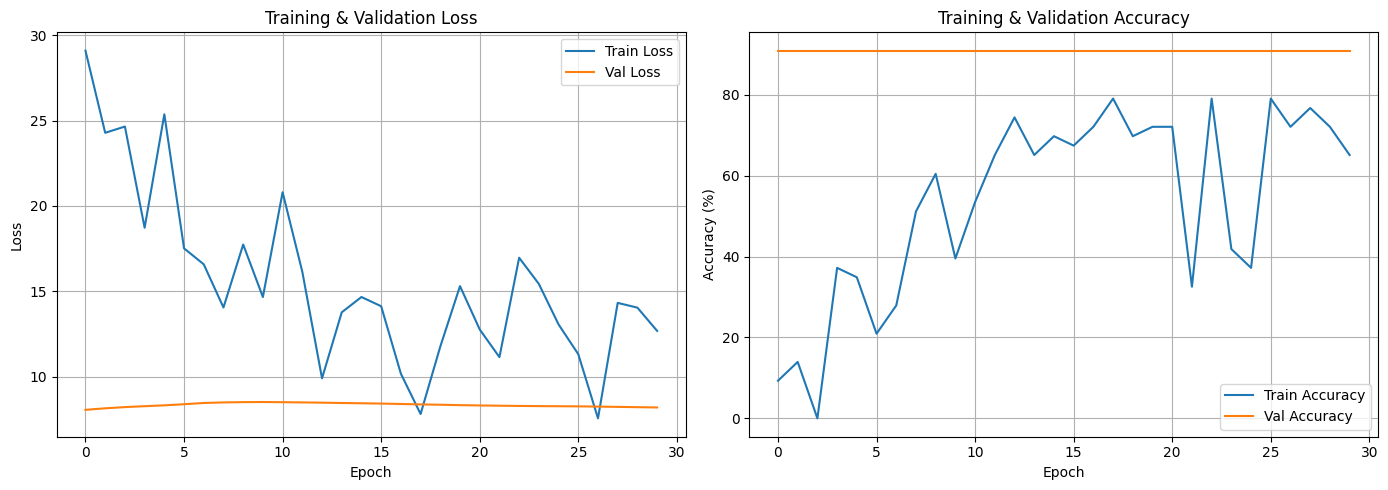

In [32]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_accuracy'], label='Train Accuracy')
axes[1].plot(history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('models/training_history.png')
plt.show()

## 7. Extract Face Embeddings & Train SVM Classifier

Setelah model MobileFaceNet di-train, kita extract embeddings dan train SVM classifier untuk face recognition.

In [33]:
# =====================================================
# Extract Embeddings & Train SVM Classifier
# =====================================================

def extract_embeddings_tf(model, images, batch_size=32):
    """Extract embeddings from model"""
    embeddings = []
    
    for i in tqdm(range(0, len(images), batch_size), desc='Extracting embeddings'):
        batch = images[i:i+batch_size]
        emb = model(batch, training=False)
        # L2 normalize
        emb = tf.nn.l2_normalize(emb, axis=1)
        embeddings.append(emb.numpy())
    
    return np.vstack(embeddings)

# Load best model
embedding_model = keras.models.load_model('models/mobilefacenet_best.keras')
with open('models/label_names.pkl', 'rb') as f:
    label_names = pickle.load(f)

print(f"✅ Loaded best model")
print(f"   Classes: {label_names}")

# Reload full dataset
images_full, labels_full, _ = load_dataset(data_dir='dataset')
images_full = preprocess_images(images_full)

# Extract embeddings
embeddings = extract_embeddings_tf(embedding_model, images_full)
print(f"\n📊 Extracted {len(embeddings)} embeddings")
print(f"   Embeddings shape: {embeddings.shape}")

✅ Loaded best model
   Classes: ['Aaron_Peirsol', 'Naufal']
✅ Loaded 54 images from 2 persons


Extracting embeddings: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


📊 Extracted 54 embeddings
   Embeddings shape: (54, 128)


In [34]:
# Train SVM Classifier
# Check if we have enough classes
unique_classes = np.unique(labels_full)
print(f"📊 Dataset Info:")
print(f"   Total samples: {len(labels_full)}")
print(f"   Unique classes: {len(unique_classes)}")
print(f"   Classes: {label_names}")

if len(unique_classes) < 2:
    print("\n⚠️ WARNING: SVM memerlukan minimal 2 class (2 orang) untuk training!")
    print("   Silakan capture dataset untuk orang lain terlebih dahulu.")
    print("   Gunakan cell 'Capture Dataset' dengan nama berbeda.")
    
    # Save classifier dengan single class (untuk testing saja)
    # Kita akan menggunakan cosine similarity sebagai fallback
    with open('models/svm_classifier.pkl', 'wb') as f:
        pickle.dump({
            'classifier': None,
            'label_names': label_names,
            'embeddings': embeddings,
            'labels': labels_full,
            'single_class': True
        }, f)
    print("\n✅ Saved single-class data for cosine similarity matching")
else:
    X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
        embeddings, labels_full, test_size=0.2, random_state=42, stratify=labels_full
    )
    
    # Train SVM
    svm_classifier = SVC(kernel='rbf', probability=True, C=10, gamma='scale')
    svm_classifier.fit(X_train_svm, y_train_svm)
    
    # Evaluate
    y_pred = svm_classifier.predict(X_test_svm)
    accuracy = accuracy_score(y_test_svm, y_pred)
    
    print(f"\n📊 SVM Classifier Results:")
    print(f"   Test Accuracy: {accuracy*100:.2f}%")
    print(f"\nClassification Report:")
    print(classification_report(y_test_svm, y_pred, target_names=label_names))
    
    # Save SVM classifier
    with open('models/svm_classifier.pkl', 'wb') as f:
        pickle.dump({
            'classifier': svm_classifier,
            'label_names': label_names,
            'single_class': False
        }, f)
        
    print("✅ SVM classifier saved to models/svm_classifier.pkl")

📊 Dataset Info:
   Total samples: 54
   Unique classes: 2
   Classes: ['Aaron_Peirsol', 'Naufal']

📊 SVM Classifier Results:
   Test Accuracy: 90.91%

Classification Report:
               precision    recall  f1-score   support

Aaron_Peirsol       0.00      0.00      0.00         1
       Naufal       0.91      1.00      0.95        10

     accuracy                           0.91        11
    macro avg       0.45      0.50      0.48        11
 weighted avg       0.83      0.91      0.87        11

✅ SVM classifier saved to models/svm_classifier.pkl


## 8. Face Recognition System

Sistem untuk mengenali wajah menggunakan model yang sudah di-train.

In [35]:
# =====================================================
# Face Recognition System Class (TensorFlow)
# =====================================================

class FaceRecognitionSystem:
    def __init__(self, model_path='models/mobilefacenet_best.keras', 
                 classifier_path='models/svm_classifier.pkl',
                 confidence_threshold=0.6):
        """
        Face Recognition System untuk absensi
        
        Args:
            model_path: path ke model MobileFaceNet
            classifier_path: path ke SVM classifier
            confidence_threshold: threshold untuk mengenali wajah
        """
        self.confidence_threshold = confidence_threshold
        
        # Load MobileFaceNet
        self.model = keras.models.load_model(model_path)
        
        # Load SVM classifier
        with open(classifier_path, 'rb') as f:
            data = pickle.load(f)
            self.classifier = data['classifier']
            self.label_names = data['label_names']
            self.single_class = data.get('single_class', False)
            
            # Untuk single class, gunakan cosine similarity
            if self.single_class:
                self.ref_embeddings = data.get('embeddings', None)
                self.ref_labels = data.get('labels', None)
                print("⚠️ Single class mode - using cosine similarity")
        
        # Face detector
        self.face_detector = FaceDetector(image_size=112, margin=20)
        
        print("✅ Face Recognition System initialized!")
        print(f"   Registered persons: {self.label_names}")
        
    def preprocess_face(self, face):
        """Preprocess face for model input"""
        # Convert BGR to RGB
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        # Normalize to [-1, 1]
        face_normalized = (face_rgb.astype(np.float32) / 127.5) - 1.0
        return face_normalized
    
    def get_embedding(self, face):
        """Extract embedding from face"""
        face_processed = self.preprocess_face(face)
        face_batch = np.expand_dims(face_processed, axis=0)
        embedding = self.model(face_batch, training=False)
        embedding = tf.nn.l2_normalize(embedding, axis=1)
        return embedding.numpy()
    
    def cosine_similarity(self, emb1, emb2):
        """Calculate cosine similarity between two embeddings"""
        return np.dot(emb1.flatten(), emb2.flatten())
    
    def recognize_face(self, frame):
        """
        Recognize face in frame
        
        Args:
            frame: BGR image from OpenCV
            
        Returns:
            name: recognized person name or "Unknown"
            confidence: confidence score
            box: bounding box
        """
        # Detect face
        face, box = self.face_detector.detect_face(frame)
        
        if face is None:
            return None, 0.0, None
        
        # Get embedding
        embedding = self.get_embedding(face)
        
        if self.single_class and self.ref_embeddings is not None:
            # Use cosine similarity for single class
            similarities = [self.cosine_similarity(embedding, ref_emb) 
                          for ref_emb in self.ref_embeddings]
            max_sim = max(similarities)
            # Convert similarity to confidence (similarity ranges from -1 to 1)
            confidence = (max_sim + 1) / 2  # Normalize to 0-1
            
            if confidence >= self.confidence_threshold:
                name = self.label_names[0]
            else:
                name = "Unknown"
        else:
            # Use SVM classifier
            proba = self.classifier.predict_proba(embedding)[0]
            max_idx = np.argmax(proba)
            confidence = proba[max_idx]
            
            if confidence >= self.confidence_threshold:
                name = self.label_names[max_idx]
            else:
                name = "Unknown"
        
        return name, confidence, box
    
    def recognize_all_faces(self, frame):
        """
        Recognize all faces in frame
        
        Returns:
            results: list of (name, confidence, box)
        """
        faces, boxes = self.face_detector.detect_all_faces(frame)
        
        results = []
        for face, box in zip(faces, boxes):
            embedding = self.get_embedding(face)
            
            if self.single_class and self.ref_embeddings is not None:
                similarities = [self.cosine_similarity(embedding, ref_emb) 
                              for ref_emb in self.ref_embeddings]
                max_sim = max(similarities)
                confidence = (max_sim + 1) / 2
                
                if confidence >= self.confidence_threshold:
                    name = self.label_names[0]
                else:
                    name = "Unknown"
            else:
                proba = self.classifier.predict_proba(embedding)[0]
                max_idx = np.argmax(proba)
                confidence = proba[max_idx]
                
                if confidence >= self.confidence_threshold:
                    name = self.label_names[max_idx]
                else:
                    name = "Unknown"
            
            results.append((name, confidence, box))
        
        return results

print("✅ FaceRecognitionSystem class defined!")

✅ FaceRecognitionSystem class defined!


## 9. Sistem Absensi Otomatis Real-time

Sistem absensi yang mencatat kehadiran secara otomatis berdasarkan face recognition.

In [36]:
# =====================================================
# Attendance System Class
# =====================================================

class AttendanceSystem:
    def __init__(self, face_recognition_system, log_dir='attendance_logs'):
        """
        Sistem Absensi Otomatis
        
        Args:
            face_recognition_system: FaceRecognitionSystem instance
            log_dir: directory untuk menyimpan log absensi
        """
        self.fr_system = face_recognition_system
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)
        
        # Attendance record untuk hari ini
        self.today = datetime.now().strftime("%Y-%m-%d")
        self.attendance_file = os.path.join(log_dir, f"attendance_{self.today}.csv")
        self.attendance_record = {}
        
        # Load existing attendance
        self._load_attendance()
        
        # Cooldown untuk mencegah multiple attendance dalam waktu singkat
        self.last_attendance_time = {}
        self.cooldown_seconds = 60  # 1 menit cooldown
        
    def _load_attendance(self):
        """Load existing attendance from file"""
        if os.path.exists(self.attendance_file):
            with open(self.attendance_file, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    if len(parts) >= 3:
                        name = parts[0]
                        self.attendance_record[name] = parts[1:]
            print(f"✅ Loaded {len(self.attendance_record)} attendance records")
    
    def _save_attendance(self, name, time_str, status='PRESENT'):
        """Save attendance to file"""
        with open(self.attendance_file, 'a') as f:
            f.write(f"{name},{time_str},{status}\n")
    
    def mark_attendance(self, name, confidence):
        """
        Mark attendance untuk seseorang
        
        Args:
            name: nama orang
            confidence: confidence score dari face recognition
            
        Returns:
            success: True jika berhasil mencatat attendance
            message: pesan status
        """
        if name == "Unknown":
            return False, "Unknown person"
        
        current_time = datetime.now()
        time_str = current_time.strftime("%H:%M:%S")
        
        # Check cooldown
        if name in self.last_attendance_time:
            elapsed = (current_time - self.last_attendance_time[name]).seconds
            if elapsed < self.cooldown_seconds:
                remaining = self.cooldown_seconds - elapsed
                return False, f"Cooldown: {remaining}s"
        
        # Check if already attended today
        if name in self.attendance_record:
            return False, f"Already marked at {self.attendance_record[name][0]}"
        
        # Mark attendance
        self.attendance_record[name] = [time_str, 'PRESENT']
        self._save_attendance(name, time_str, 'PRESENT')
        self.last_attendance_time[name] = current_time
        
        return True, f"✅ Attendance marked at {time_str}"
    
    def get_attendance_summary(self):
        """Get attendance summary for today"""
        registered = self.fr_system.label_names
        present = list(self.attendance_record.keys())
        absent = [p for p in registered if p not in present]
        
        return {
            'date': self.today,
            'total_registered': len(registered),
            'present': len(present),
            'absent': len(absent),
            'present_names': present,
            'absent_names': absent,
            'records': self.attendance_record
        }

print("✅ AttendanceSystem class defined!")

✅ AttendanceSystem class defined!


In [37]:
# =====================================================
# Real-time Attendance Function
# =====================================================

def run_attendance_system(confidence_threshold=0.6):
    """
    Jalankan sistem absensi real-time
    
    Controls:
        Q - Quit
        S - Show attendance summary
    """
    # Initialize systems
    fr_system = FaceRecognitionSystem(
        model_path='models/mobilefacenet_best.keras',
        classifier_path='models/svm_classifier.pkl',
        confidence_threshold=confidence_threshold
    )
    attendance_system = AttendanceSystem(fr_system)
    
    # Open webcam
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    if not cap.isOpened():
        print("Error: Cannot open webcam")
        return
    
    print("\n🎯 Attendance System Started!")
    print("Controls:")
    print("   Q - Quit")
    print("   S - Show attendance summary")
    print("\n")
    
    notification_message = ""
    notification_time = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.flip(frame, 1)
        display_frame = frame.copy()
        
        # Face recognition
        name, confidence, box = fr_system.recognize_face(frame)
        
        # Draw detection
        if box is not None:
            x1, y1, x2, y2 = [int(b) for b in box]
            
            # Color based on recognition
            if name == "Unknown":
                color = (0, 0, 255)  # Red
            else:
                color = (0, 255, 0)  # Green
            
            cv2.rectangle(display_frame, (x1, y1), (x2, y2), color, 2)
            
            # Draw name and confidence
            label = f"{name} ({confidence:.2f})"
            cv2.putText(display_frame, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            
            # Try to mark attendance
            if name != "Unknown" and confidence >= confidence_threshold:
                success, message = attendance_system.mark_attendance(name, confidence)
                if success:
                    notification_message = f"✅ {name}: {message}"
                    notification_time = cv2.getTickCount()
                    print(notification_message)
        
        # Draw header
        cv2.rectangle(display_frame, (0, 0), (640, 80), (50, 50, 50), -1)
        cv2.putText(display_frame, "ATTENDANCE SYSTEM (TensorFlow)", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(display_frame, f"Date: {attendance_system.today}", (10, 55), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 200), 1)
        
        # Draw attendance count
        summary = attendance_system.get_attendance_summary()
        cv2.putText(display_frame, f"Present: {summary['present']}/{summary['total_registered']}", 
                   (450, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        # Draw notification
        current_tick = cv2.getTickCount()
        if notification_message and (current_tick - notification_time) / cv2.getTickFrequency() < 3:
            cv2.rectangle(display_frame, (0, 400), (640, 440), (0, 100, 0), -1)
            cv2.putText(display_frame, notification_message, (10, 425), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        # Draw footer
        cv2.rectangle(display_frame, (0, 440), (640, 480), (50, 50, 50), -1)
        cv2.putText(display_frame, "Press Q to Quit | S for Summary", (10, 465), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 200), 1)
        
        cv2.imshow('Attendance System', display_frame)
        
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q'):
            break
        elif key == ord('s'):
            # Show summary
            print("\n" + "="*50)
            print("📊 ATTENDANCE SUMMARY")
            print("="*50)
            print(f"Date: {summary['date']}")
            print(f"Present: {summary['present']}/{summary['total_registered']}")
            print(f"\n✅ Present: {', '.join(summary['present_names']) if summary['present_names'] else 'None'}")
            print(f"❌ Absent: {', '.join(summary['absent_names']) if summary['absent_names'] else 'None'}")
            print("\nRecords:")
            for name, record in summary['records'].items():
                print(f"   {name}: {record[0]} - {record[1]}")
            print("="*50 + "\n")
    
    cap.release()
    cv2.destroyAllWindows()
    
    # Final summary
    print("\n" + "="*50)
    print("📊 FINAL ATTENDANCE REPORT")
    print("="*50)
    summary = attendance_system.get_attendance_summary()
    print(f"Date: {summary['date']}")
    print(f"Present: {summary['present']}/{summary['total_registered']}")
    print(f"\n✅ Present:")
    for name, record in summary['records'].items():
        print(f"   - {name}: {record[0]}")
    if summary['absent_names']:
        print(f"\n❌ Absent:")
        for name in summary['absent_names']:
            print(f"   - {name}")
    print("="*50)
    
    return summary

print("✅ Real-time attendance function defined!")

✅ Real-time attendance function defined!


### 9.1 Jalankan Sistem Absensi

⚠️ **Pastikan model sudah di-train sebelum menjalankan sistem absensi!**

In [38]:
# Jalankan sistem absensi
# Tekan Q untuk keluar
attendance_summary = run_attendance_system(confidence_threshold=0.6)

✅ Using OpenCV DNN face detector
✅ Face Recognition System initialized!
   Registered persons: ['Aaron_Peirsol', 'Naufal']

🎯 Attendance System Started!
Controls:
   Q - Quit
   S - Show attendance summary


✅ Naufal: ✅ Attendance marked at 23:54:49

📊 ATTENDANCE SUMMARY
Date: 2026-01-23
Present: 1/2

✅ Present: Naufal
❌ Absent: Aaron_Peirsol

Records:
   Naufal: 23:54:49 - PRESENT


📊 ATTENDANCE SUMMARY
Date: 2026-01-23
Present: 1/2

✅ Present: Naufal
❌ Absent: Aaron_Peirsol

Records:
   Naufal: 23:54:49 - PRESENT


📊 ATTENDANCE SUMMARY
Date: 2026-01-23
Present: 1/2

✅ Present: Naufal
❌ Absent: Aaron_Peirsol

Records:
   Naufal: 23:54:49 - PRESENT


📊 FINAL ATTENDANCE REPORT
Date: 2026-01-23
Present: 1/2

✅ Present:
   - Naufal: 23:54:49

❌ Absent:
   - Aaron_Peirsol


## 10. Utility Functions

Fungsi tambahan untuk manajemen sistem.

In [ ]:
# =====================================================
# Utility Functions
# =====================================================

def add_new_person(person_name, num_images=50):
    """
    Tambah orang baru ke dataset dan retrain model
    
    1. Capture dataset baru
    2. Retrain model
    3. Update SVM classifier
    """
    print(f"📸 Adding new person: {person_name}")
    
    # Step 1: Capture dataset
    capture_dataset(person_name, num_images=num_images)
    
    print(f"\n⚠️ After capturing, please retrain the model by running:")
    print("   1. Cell 'Load dataset'")
    print("   2. Cell 'Initialize Trainer'")
    print("   3. Cell 'Training Loop'")
    print("   4. Cell 'Extract Embeddings & Train SVM'")

def view_attendance_logs(date=None):
    """
    Lihat log absensi
    
    Args:
        date: format YYYY-MM-DD, default hari ini
    """
    if date is None:
        date = datetime.now().strftime("%Y-%m-%d")
    
    log_file = f"attendance_logs/attendance_{date}.csv"
    
    if not os.path.exists(log_file):
        print(f"No attendance log for {date}")
        return
    
    print(f"\n📊 Attendance Log for {date}")
    print("-" * 50)
    print(f"{'Name':<20} {'Time':<15} {'Status':<10}")
    print("-" * 50)
    
    with open(log_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 3:
                print(f"{parts[0]:<20} {parts[1]:<15} {parts[2]:<10}")
    
    print("-" * 50)

def test_face_recognition():
    """
    Test face recognition dengan webcam tanpa attendance tracking
    """
    fr_system = FaceRecognitionSystem(
        model_path='models/mobilefacenet_best.keras',
        classifier_path='models/svm_classifier.pkl',
        confidence_threshold=0.5
    )
    
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    print("🎯 Face Recognition Test - Press Q to quit")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.flip(frame, 1)
        
        # Recognize
        name, confidence, box = fr_system.recognize_face(frame)
        
        # Draw
        if box is not None:
            x1, y1, x2, y2 = [int(b) for b in box]
            color = (0, 255, 0) if name != "Unknown" else (0, 0, 255)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f"{name} ({confidence:.2f})", (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        cv2.imshow('Face Recognition Test', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

print("✅ Utility functions defined!")
print("\nAvailable functions:")
print("   - add_new_person(name, num_images): Tambah orang baru")
print("   - view_attendance_logs(date): Lihat log absensi")
print("   - test_face_recognition(): Test face recognition")

In [ ]:
# Test face recognition (tanpa attendance tracking)
# test_face_recognition()

In [ ]:
# Lihat log absensi hari ini
# view_attendance_logs()

## 📋 Cara Penggunaan (TensorFlow Version)

### Langkah-langkah:

1. **Install Dependencies** (Cell 3)
   - Jalankan cell untuk install TensorFlow dan dependencies lainnya

2. **Import Libraries** (Cell 4)
   - Jalankan untuk import semua module

3. **Load Architecture** (Cell 6)
   - Jalankan untuk load arsitektur MobileFaceNet

4. **Initialize Face Detector** (Cell 8)
   - Jalankan untuk initialize face detector

5. **Capture Dataset** (Section 4)
   - Ubah `person_name` sesuai nama orang
   - Jalankan cell capture untuk setiap orang yang ingin didaftarkan
   - Minimal 30-50 gambar per orang untuk hasil optimal
   - Gunakan variasi pose dan pencahayaan

6. **Training Model** (Section 5-6)
   - Jalankan semua cell di section 5 dan 6 secara berurutan
   - Tunggu training selesai (sekitar 30 epoch)

7. **Train SVM Classifier** (Section 7)
   - Jalankan untuk extract embeddings dan train SVM

8. **Jalankan Sistem Absensi** (Section 9)
   - Jalankan cell untuk memulai sistem absensi real-time
   - Wajah yang dikenali akan otomatis dicatat kehadirannya
   - Tekan Q untuk keluar

### Keunggulan TensorFlow Version:
- Tidak memerlukan PyTorch
- Lebih stabil di berbagai environment
- Support GPU dengan TensorFlow
- Face detection menggunakan OpenCV DNN (lebih ringan)

### Tips:
- Pastikan pencahayaan cukup saat capture dataset
- Variasikan pose wajah (menghadap kiri, kanan, atas, bawah)
- Gunakan minimal 3 orang untuk training yang lebih baik
- Confidence threshold 0.6 sudah cukup untuk kebanyakan kasus